In [ ]:

import matplotlib.pyplot as plt


import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *


libraries_path = find_libraries()
spice_library = SpiceLibrary(libraries_path)



circuit = Circuit('Buck Converter')

circuit.include(spice_library['1N5822']) # Schottky diode
circuit.include(spice_library['irf150'])

# From Microchip WebSeminars - Buck Converter Design Example

Vin = 12@u_V
Vout = 5@u_V
ratio = Vout / Vin

Iload = 2@u_A
Rload = Vout / (.8 * Iload)

frequency = 400@u_kHz
period = frequency.period
duty_cycle = ratio * period

ripple_current = .3 * Iload # typically 30 %
ripple_voltage = 50@u_mV

print('ratio =', ratio)
print('RLoad =', Rload)
print('period =', period.canonise())
print('duty_cycle =', duty_cycle.canonise())
print('ripple_current =', ripple_current)



ratio = 0.4166666666666667 sr
RLoad = 3.125 Ω
period = 2.5000000000000004 μs
duty_cycle = 1.0416666666666667 μs
ripple_current = 0.6 A


In [ ]:

L = (Vin - Vout) * duty_cycle / ripple_current
RL = 37@u_mΩ



L = 12.152777777777779 μH
Cout = 19.53125 μF
Cint = 13.020833333333332 μF


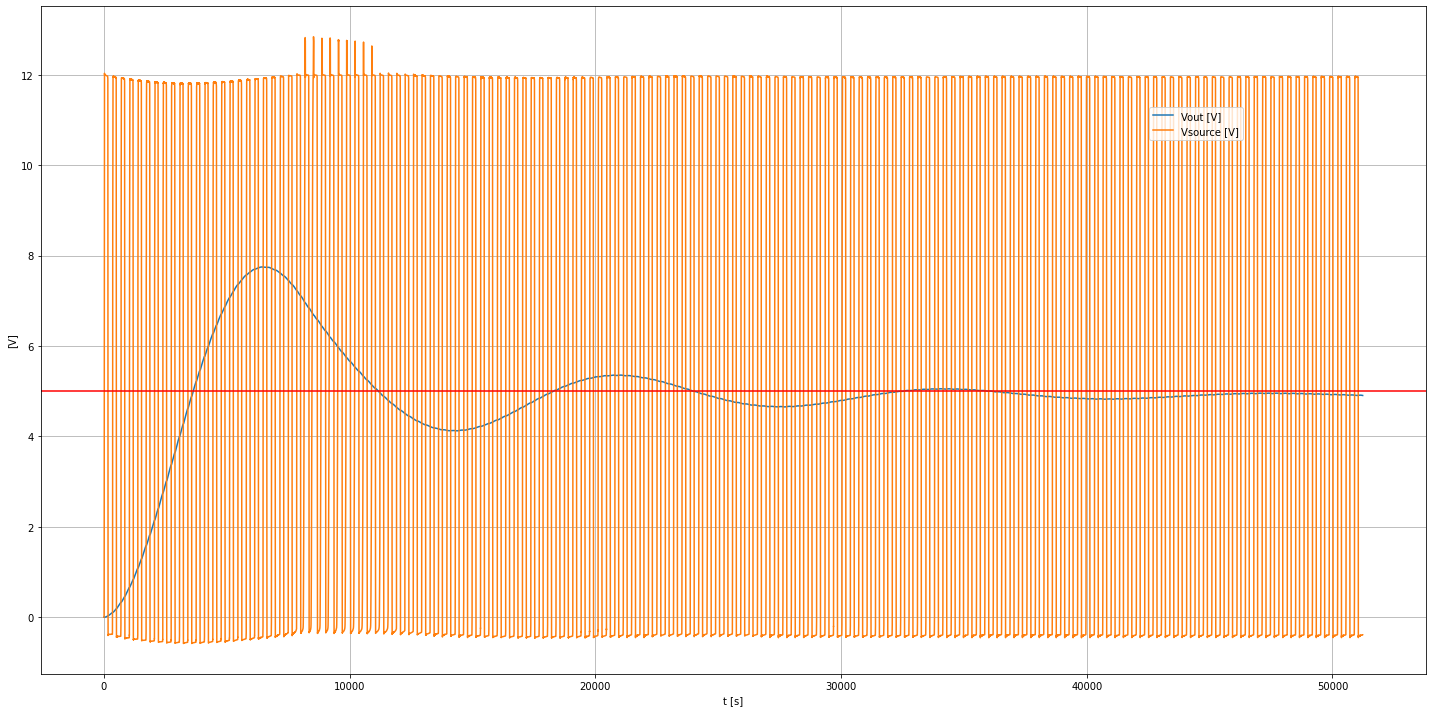

In [ ]:

ESR = 30@u_mΩ
ESL = 0
Cout = (ripple_current * duty_cycle) / (ripple_voltage - ripple_current * ESR)

ripple_current_in = Iload / 2
ripple_voltage_in = 200@u_mV
ESR_in = 120@u_mΩ
Cin = duty_cycle / (ripple_voltage_in / ripple_current_in - ESR_in)

L = L.canonise()
Cout = Cout.canonise()
Cin = Cin.canonise()

print('L =', L)
print('Cout =', Cout)
print('Cint =', Cin)

circuit.V('in', 'in', circuit.gnd, Vin)
circuit.C('in', 'in', circuit.gnd, Cin)

# Fixme: out drop from 12V to 4V
# circuit.VCS('switch', 'gate', circuit.gnd, 'in', 'source', model='Switch', initial_state='off')
# circuit.PulseVoltageSource('pulse', 'gate', circuit.gnd, 0@u_V, Vin, duty_cycle, period)
# circuit.model('Switch', 'SW', ron=1@u_mΩ, roff=10@u_MΩ)

# Fixme: Vgate => Vout ???
circuit.X('Q', 'irf150', 'in', 'gate', 'source')
# circuit.PulseVoltageSource('pulse', 'gate', 'source', 0@u_V, Vin, duty_cycle, period)
circuit.R('gate', 'gate', 'clock', 1@u_Ω)
circuit.PulseVoltageSource('pulse', 'clock', circuit.gnd, 0@u_V, 2.*Vin, duty_cycle, period)

circuit.X('D', '1N5822', circuit.gnd, 'source')
circuit.L(1, 'source', 1, L)
circuit.R('L', 1, 'out', RL)
circuit.C(1, 'out', circuit.gnd, Cout) # , initial_condition=0@u_V
circuit.R('load', 'out', circuit.gnd, Rload)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=period/300, end_time=period*150)

figure, ax = plt.subplots(figsize=(20, 10))

ax.plot(analysis.out)
ax.plot(analysis['source'])
# ax.plot(analysis['source'] - analysis['out'])
# ax.plot(analysis['gate'])
ax.axhline(y=float(Vout), color='red')
ax.legend(('Vout [V]', 'Vsource [V]'), loc=(.8,.8))
ax.grid()
ax.set_xlabel('t [s]')
ax.set_ylabel('[V]')

plt.tight_layout()

